In [275]:
import cv2 as cv
import numpy as np
import random as rng
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

rng.seed(12345)

In [276]:
def find_bounds(pts):
    x_left = np.int16(pts[:,0].min())
    x_right = np.int16(pts[:,0].max())
    y_top = np.int16(pts[:,1].min())
    y_bot = np.int16(pts[:,1].max())
    return x_left, x_right, y_top, y_bot

def combine_contours(contours):
    combined_cont = np.array(contours[0].reshape(-1, 2))
    # print(f'combined_cont shape: {combined_cont.shape}')
    for i in range(1, len(contours)):
        combined_cont = np.vstack((combined_cont, contours[i].reshape(-1, 2)))
    return combined_cont

def get_hull(contours):
    print(f'contours len = {len(contours)}')
    total_cont = combine_contours(contours)
    print(f'total_cont shape = {total_cont.shape}')
    hull = cv.convexHull(total_cont)
    return hull.reshape(-1, 2)

def plot_circles(points, image, radius = 50, color = (0, 0, 255), thickness = 6):
    for point in points:
        x, y = point.ravel()
        cv.circle(image, (x, y), radius = radius, color = color, thickness = thickness)
    return image

def plot_hull(image, points, approx_ratio = 0.05):
    
    # threshold = val
    
    # Detect edges using Canny
    # canny_output = cv.Canny(image, threshold, threshold * 2)
    
    # Find contours
    # contours, _ = cv.findContours(canny_output, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    image_hull = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
    hull = get_hull(points)
    cv.drawContours(image_hull, [hull], -1, color = (255, 0, 0), thickness = 10)
    image_hull = plot_circles(hull, image_hull, color = (255, 0, 0), radius = 20)
    print(f'hull shape = {hull.shape}')
    epsilon = approx_ratio * cv.arcLength(hull, True)
    approx = cv.approxPolyDP(hull, epsilon, True)
    print(f'approx len = {len(approx)}')
    image_hull = plot_circles(approx, image_hull, color = (255, 255, 255), radius = 40)
    plt.imshow(image_hull)
    plt.title('HULL')
    plt.show()

    return image_hull, approx.reshape(-1, 2)

def canny_contours(src_gray, threshold):
    # Detect edges using Canny
    canny_output = cv.Canny(src_gray, threshold, threshold * 2)
    # Find contours
    contours, hierarchy = cv.findContours(canny_output, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    # Find the convex hull object for each contour
    hull_list = []
    for i in range(len(contours)):
        hull = cv.convexHull(contours[i])
        hull_list.append(hull)
    # Draw contours with convex hulls around each countour
    drawing = np.zeros((canny_output.shape[0], canny_output.shape[1], 3), dtype=np.uint8)
    for i in range(len(contours)):
        color = (rng.randint(0,256), rng.randint(0,256), rng.randint(0,256))
        cv.drawContours(drawing, contours, i, color, 2, cv.LINE_8, hierarchy, 0)
        cv.drawContours(drawing, hull_list, i, color)
    plt.imshow(drawing)
    plt.imsave("contours_and_convexes.jpg", drawing)
    plt.show()
    return contours

def points_from_contours(contours):
    # Draw boundary box
    points = np.array([contours[0].reshape(-1,2)[0]])
    for contour in contours:
        points= np.append(points, contour.reshape(-1,2), axis=0)
    return points

def sort_dbscan(points, eps, min_samples, dbscan_thr):
    dbscan_model = DBSCAN(eps=eps, min_samples=min_samples)
    dbscan_model.fit(points)
    dbscan_res = dbscan_model.fit_predict(points) # 1d array of labels corresponding to points
    dbscan_clstrs = np.unique(dbscan_res) # 1d array of all possible labels (ascending)

    # find cluster populations according to labels
    if dbscan_clstrs[0] == -1:
        num_of_outliers = (dbscan_res == 1).sum()
        dbscan_clstrs = dbscan_clstrs[1:]
    populations = np.zeros(dbscan_clstrs.shape[0])
    for i,dbscan_clstr in enumerate(dbscan_clstrs):
        cond = dbscan_res == dbscan_clstr
        populations[i] = cond.sum()
    
    # sorting and leaving only good labels
    mask = populations >= (populations.min() + (populations.max()-populations.min())*dbscan_thr)
    good_cluster_labels = dbscan_clstrs[mask]
    
    # find good points
    good_points = []
    for dbscan_clstr in good_cluster_labels:
        cond = dbscan_res == dbscan_clstr
        # np.nonzero(cond) returns tuple, of arrays ([i-indices],[j-indices])
        # since we have 1d-array we will get ([i-indices],)
        # so we still need to call 0-th element of tuple to get i-indices
        indices = np.nonzero(cond)[0]
        good_points.extend(points[indices])
        plt.scatter(points[indices][:,0], (-1)*points[indices][:,1], s=0.5)
    ax = plt.gca()
    ax.set_aspect('equal', adjustable='box')
    plt.show()
    good_points = np.array(good_points)

    return good_points

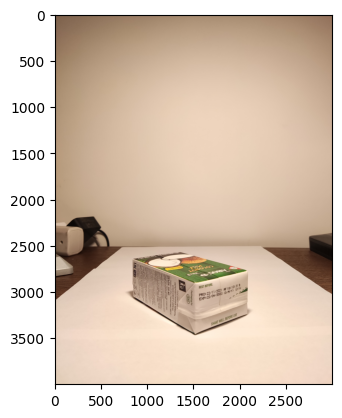

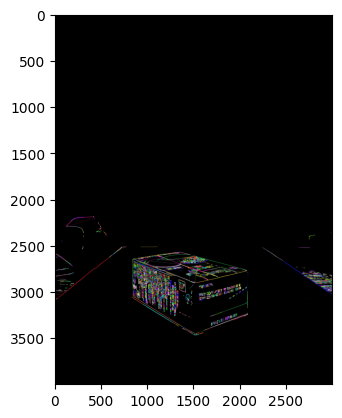

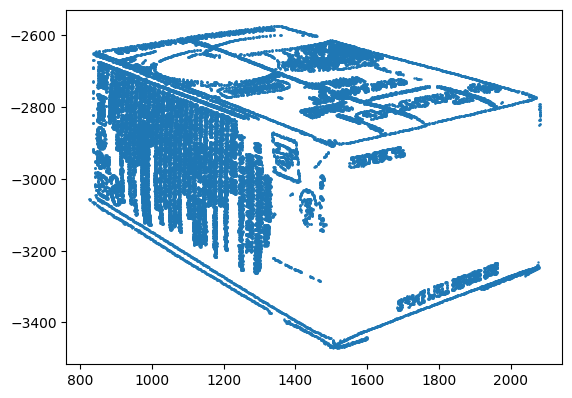

contours len = 58865
total_cont shape = (58865, 2)
hull shape = (38, 2)
approx len = 6


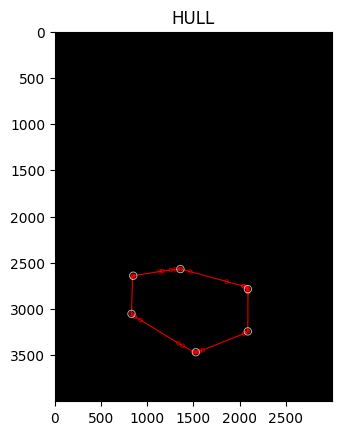

[[2081 2790]
 [2080 3247]
 [1519 3472]
 [ 825 3057]
 [ 844 2645]
 [1353 2573]]
[1450 2964]


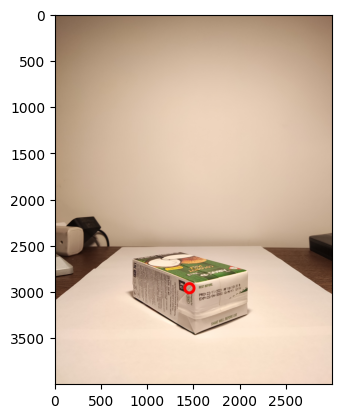

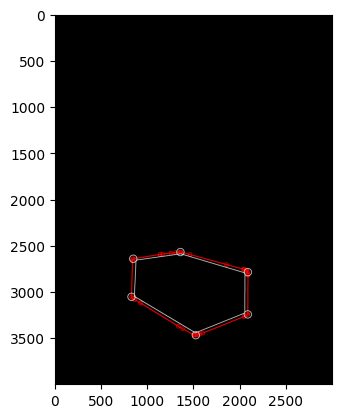

In [277]:
src = cv.imread("stereo3/1.jpg")
src = cv.cvtColor(src, cv.COLOR_BGR2RGB)
plt.imshow(src)
plt.show()
src_gray = cv.cvtColor(src, cv.COLOR_BGR2GRAY)
threshold = 100
contours = canny_contours(src_gray, threshold)
points = points_from_contours(contours)
good_points = sort_dbscan(points, eps=50, min_samples=50, dbscan_thr=1)
# x1,x2,y1,y2 = find_bounds(points)
hull_img, corners = plot_hull(src, good_points, approx_ratio = 0.01)
print(corners)

mass_center = corners.mean(axis=0).astype(np.uint16)
print(mass_center)
cv.circle(src, mass_center, radius = 50, color = (255,0,0), thickness = 30)
plt.imshow(src)
plt.show()

def dist(point, mass_center):
    return mass_center - point

for i, corner in enumerate(corners):
    corners[i] = corner + dist(corner, mass_center) * 0.05

cv.drawContours(hull_img, [corners], -1, (255,255,255), thickness=5)
plt.imshow(hull_img)
plt.show()

[[0.    0.    0.   ]
 [0.025 0.    0.   ]
 [0.05  0.    0.   ]
 [0.075 0.    0.   ]
 [0.1   0.    0.   ]
 [0.125 0.    0.   ]
 [0.15  0.    0.   ]
 [0.175 0.    0.   ]
 [0.2   0.    0.   ]
 [0.    0.025 0.   ]
 [0.025 0.025 0.   ]
 [0.05  0.025 0.   ]
 [0.075 0.025 0.   ]
 [0.1   0.025 0.   ]
 [0.125 0.025 0.   ]
 [0.15  0.025 0.   ]
 [0.175 0.025 0.   ]
 [0.2   0.025 0.   ]
 [0.    0.05  0.   ]
 [0.025 0.05  0.   ]
 [0.05  0.05  0.   ]
 [0.075 0.05  0.   ]
 [0.1   0.05  0.   ]
 [0.125 0.05  0.   ]
 [0.15  0.05  0.   ]
 [0.175 0.05  0.   ]
 [0.2   0.05  0.   ]
 [0.    0.075 0.   ]
 [0.025 0.075 0.   ]
 [0.05  0.075 0.   ]
 [0.075 0.075 0.   ]
 [0.1   0.075 0.   ]
 [0.125 0.075 0.   ]
 [0.15  0.075 0.   ]
 [0.175 0.075 0.   ]
 [0.2   0.075 0.   ]
 [0.    0.1   0.   ]
 [0.025 0.1   0.   ]
 [0.05  0.1   0.   ]
 [0.075 0.1   0.   ]
 [0.1   0.1   0.   ]
 [0.125 0.1   0.   ]
 [0.15  0.1   0.   ]
 [0.175 0.1   0.   ]
 [0.2   0.1   0.   ]
 [0.    0.125 0.   ]
 [0.025 0.125 0.   ]
 [0.05  0.125

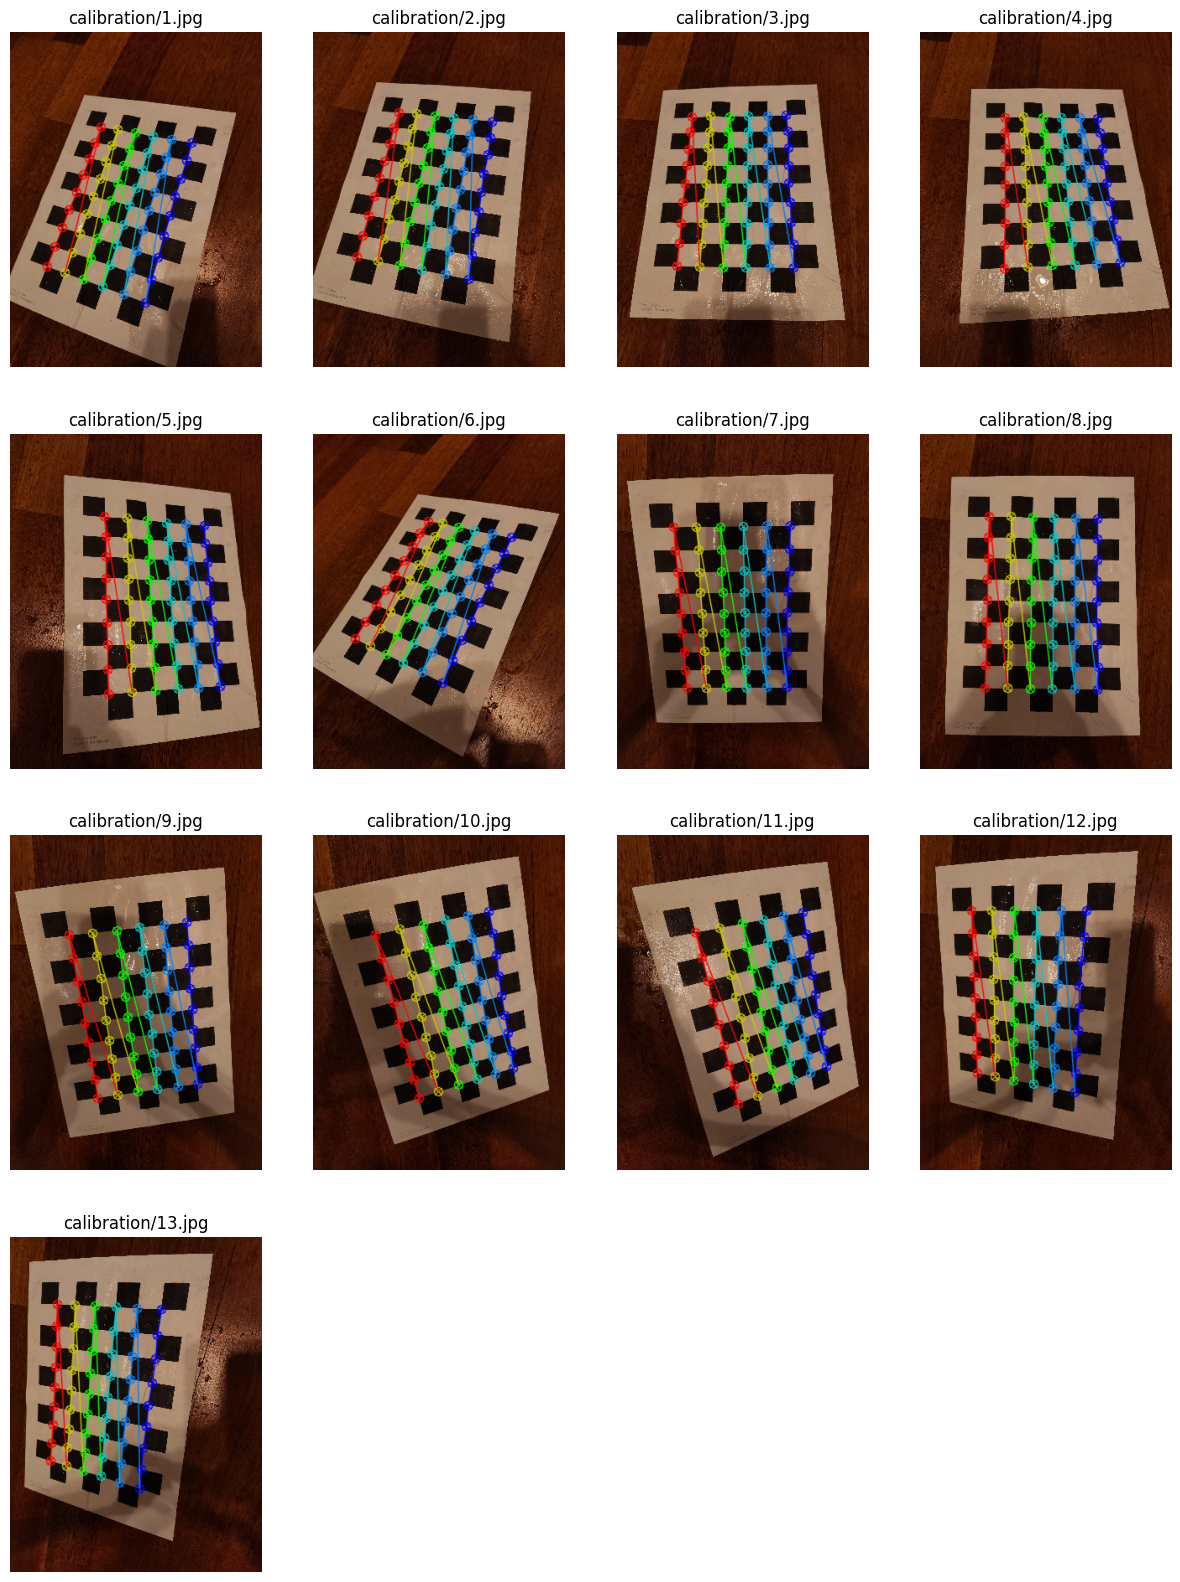

In [278]:
_ = plt.figure(figsize=(15,20))
paths = []
for i in range(13):
    paths.append(f"calibration/{i+1}.jpg")
# print(paths)
objp = np.zeros((6 * 9, 3), np.float32)
objp[:, :2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2) * 0.025 # 3d points in real world space (ideal case)
print(objp)
img_points = []  # 2d points in image plane.
obj_points = [] # 3d points in real world space (ideal case)
for i, path in enumerate(paths):
    img = cv.imread(path)
    img = cv.resize(img, (300, 400))
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    img_gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
    # plt.imshow(img_gray)
    # plt.show()
    result, chb_corners = cv.findChessboardCorners(img_gray, (9, 6), None)
    print(result)
    if result:
        obj_points.append(objp)
        img_points.append(chb_corners)
        cv.drawChessboardCorners(img, (9, 6), chb_corners, result)
        plt.subplot(4, 4, i + 1)
        plt.title(path, fontsize=12)
        plt.axis('off')
        plt.imshow(img)
plt.show()
plt.imsave("calibration.jpg", img)

In [279]:
img = cv.imread("calibration/8.jpg")
img = cv.resize(img, (300, 400))
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
img_gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)

result, intrinsics, dist, r_vecs, t_vecs = cv.calibrateCamera(
    objectPoints=obj_points,
    imagePoints=img_points,
    imageSize=img_gray.shape[::-1],
    cameraMatrix=None,
    distCoeffs=None
)
intrinsics[:2,:] = intrinsics[:2,:] / 0.025 # 0.025 is chessboard cell size
print(f'Camera matrix:\n{intrinsics}')
print(f'Distortion coefficients:\n{dist}')


Camera matrix:
[[1.24086515e+04 0.00000000e+00 6.07734103e+03]
 [0.00000000e+00 1.20862455e+04 7.86567201e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Distortion coefficients:
[[ 1.97420760e-01 -1.10204458e+00  1.25653127e-03  5.79265300e-03
   2.43828890e+00]]


In [280]:
# rows, cols = img.shape[:2]
# new_intrinsics, roi = cv.getOptimalNewCameraMatrix(
#     cameraMatrix=intrinsics,
#     distCoeffs=dist,
#     imageSize=(cols, rows),
#     alpha=1,
#     newImgSize=(cols, rows)
# )
# roi_x, roi_y, roi_w, roi_h = roi
# print(f'New camera matrix:\n{new_intrinsics}')
# print(f'Region of interest:\n{roi}')

# undistorted_img = cv.undistort(
#     src=img,
#     cameraMatrix=intrinsics,
#     distCoeffs=dist,
#     dst=None,
#     newCameraMatrix=new_intrinsics
# )
# undistorted_img_cropped = undistorted_img[roi_y:roi_y + roi_h, roi_x:roi_x + roi_w]

# fig = plt.figure(figsize=(10, 7))
# fig.add_subplot(1, 2, 1)
# plt.imshow(undistorted_img)
# plt.axis('off')
# plt.title("Undistorted image")
# fig.add_subplot(1, 2, 2)
# plt.imshow(undistorted_img_cropped)
# plt.axis('off')
# plt.title("Undistorted image (cropped)")

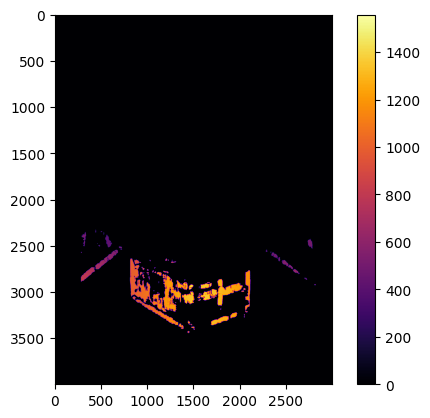

In [281]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

imgL = cv.imread('stereo3/1.jpg')
imgR = cv.imread('stereo3/2.jpg')
imgL = cv.cvtColor(imgL, cv.COLOR_BGR2GRAY)
imgR = cv.cvtColor(imgR, cv.COLOR_BGR2GRAY)

# nums = [16, 64, 256, 512, 1024]
# for num in nums:
stereo = cv.StereoBM_create(numDisparities=256, blockSize=51)
disp_stereo = stereo.compute(imgL,imgR)
# plt.imshow(disp_stereo,'inferno')
# plt.imsave("disparity.jpg", disp_stereo, cmap="inferno")
# plt.show()
filtered_disp_stereo, idontknow  = cv.filterSpeckles(disp_stereo, newVal=0, maxSpeckleSize=50, maxDiff=1)
filtered_disp_stereo = np.maximum(0, filtered_disp_stereo) # element-wise max operator
# cv.drawContours(filtered_disp_stereo, [corners], -1, (255,255,255), 20)
plt.imshow(filtered_disp_stereo,'inferno')
plt.colorbar()
plt.imsave("filtered.jpg", filtered_disp_stereo, cmap="inferno")
plt.show()

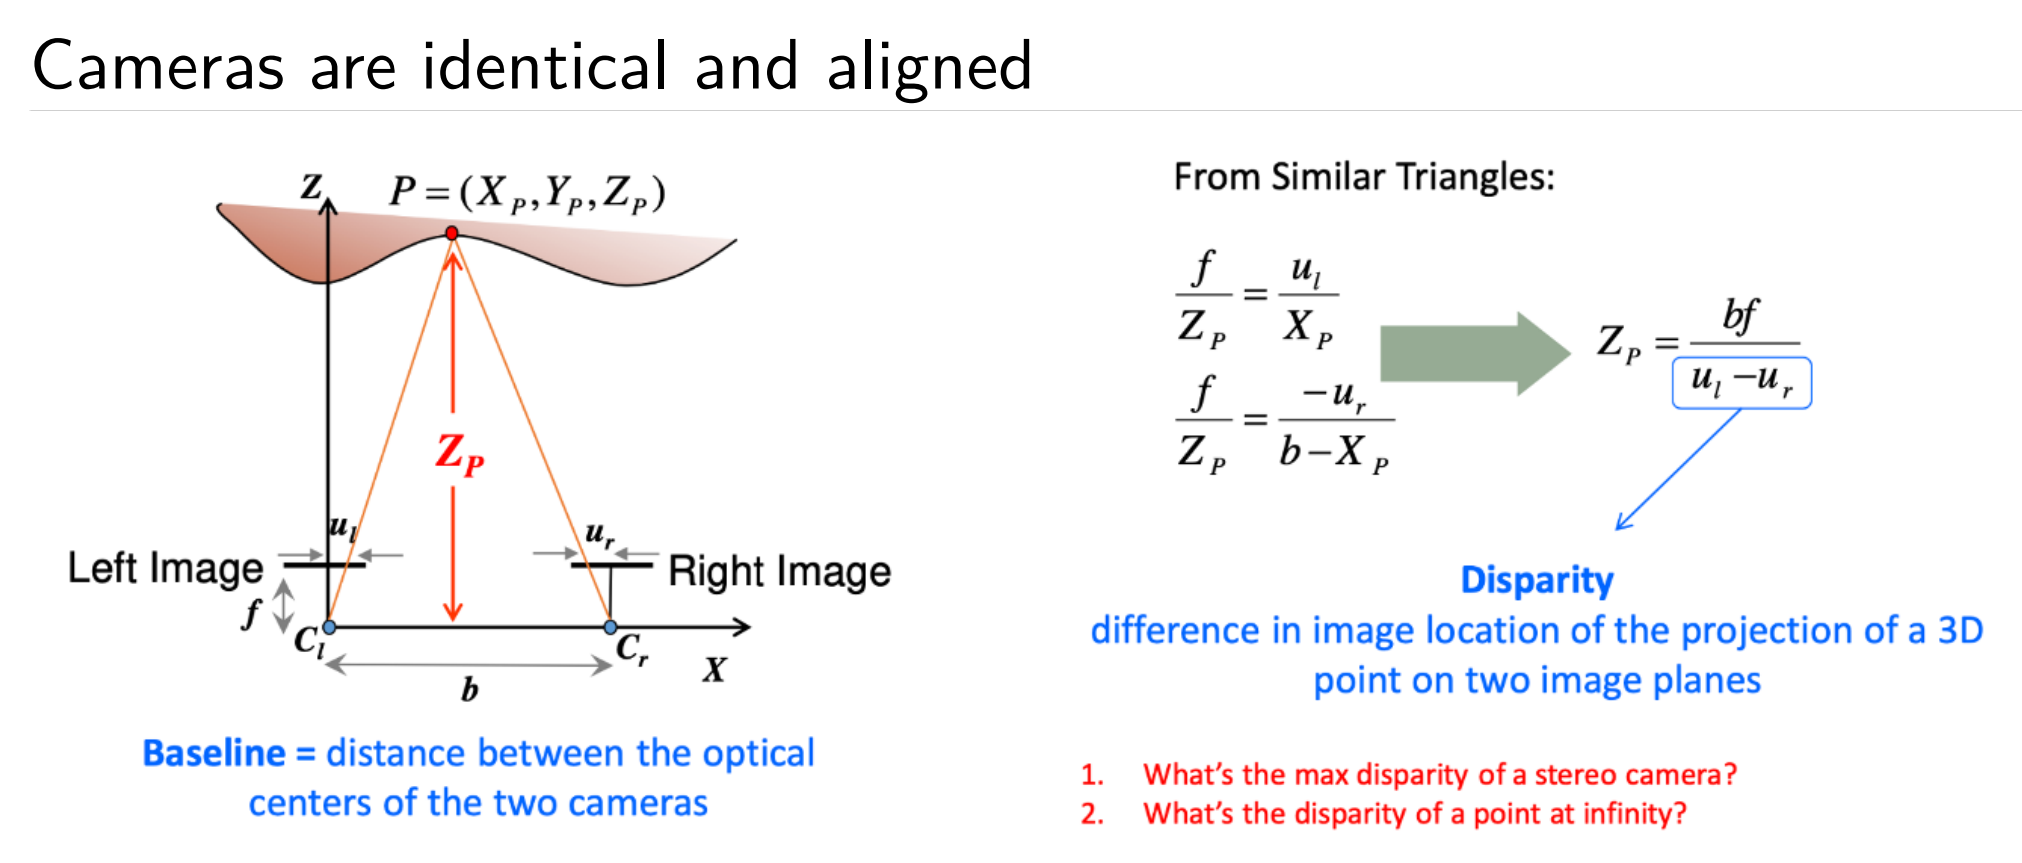

In [282]:
def get_world_coords(x, y, intrinsics):
    """return physical coordinates in mm
    Keyword arguments:
    x, y -- coordinates of a point in pixels
    depth -- depth coordiante of the same point
    intrinsics -- 3x3 matrix with focal lengthes and principial point"""
    f = np.linalg.inv(intrinsics)
    v = np.array([x,y,1])
    return np.dot(f,v)

def plot_points_3d(points):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    # ax.scatter(points[:,0], points[:,1], points[:,2], c='b', marker='o')  # Scatter plot of the points
    for i in range(len(points)):
        ax.scatter(points[i,0], points[i,2], -points[i,1])
    ax.set_xlabel('X')
    ax.set_ylabel('Z')
    ax.set_zlabel('Y')
    plt.show()
    return None

def find_rw(corners, disp_map, intrinsics, b):
    corners_3d = np.zeros((len(corners), 3), dtype = np.float32)
    f_x = intrinsics[0,0]
    f_y = intrinsics[1,1]
    f = np.sqrt(f_x**2+f_y**2)
    # b = 0.05 # meters, actually i don't know how much distance was btw 2 cameras
    # print(corners)
    for i_corner, corner in enumerate(corners):
        # eps = 1
        # disparity = []
        x, y = corner
        # mask = disp_map[y-eps:y+eps, x-eps:x+eps] > 0
        # disparity = (disp_map[y-50:y+50, x-50:x+50] * mask).sum() / mask.sum()
        disparity = disp_map[y,x]
        # print(disparity)
        depth = b*f / disparity
        # print(depth)
        corners_3d[i_corner, :] = get_world_coords(x, y, intrinsics)
        corners_3d[i_corner, 2] = depth
    return corners_3d

def get_object_size(coords_rw):
    distances = []
    for i in range(len(coords_rw) - 1):
        distance = np.linalg.norm(coords_rw[i] - coords_rw[i + 1])
        distances.append(distance)
    return distances

In [283]:
import torch

def predict_image(image, model, transform):
    input_batch = transform(image).to(device)
    with torch.no_grad():
        prediction = model(input_batch)
        prediction = torch.nn.functional.interpolate(
            prediction.unsqueeze(1),
            size=image.shape[:2],
            mode="bicubic",
            align_corners=False,
        ).squeeze()
    output = prediction.cpu().numpy()
    return output

# model_type = 'DPT_Large'
model_type = 'DPT_Hybrid'
midas = torch.hub.load("intel-isl/MiDaS", model_type)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
midas.to(device)
midas.eval()

midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")

if model_type == "DPT_Large" or model_type == "DPT_Hybrid":
    transform = midas_transforms.dpt_transform
else:
    transform = midas_transforms.small_transform



Using cache found in /home/anuar/.cache/torch/hub/intel-isl_MiDaS_master
/home/anuar/.local/lib/python3.10/site-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name vit_base_resnet50_384 to current vit_base_r50_s16_384.orig_in21k_ft_in1k.
  model = create_fn(
Using cache found in /home/anuar/.cache/torch/hub/intel-isl_MiDaS_master


In [284]:
img = cv.imread("stereo3/1.jpg")
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

disp_midas = predict_image(img, midas, transform)

[[277.14465 277.17395 277.08588 ... 251.2916  249.72963 250.2494 ]
 [277.20825 277.2379  277.1487  ... 250.77936 249.20805 249.73093]
 [277.01706 277.0456  276.95978 ... 252.31941 250.77618 251.2897 ]]


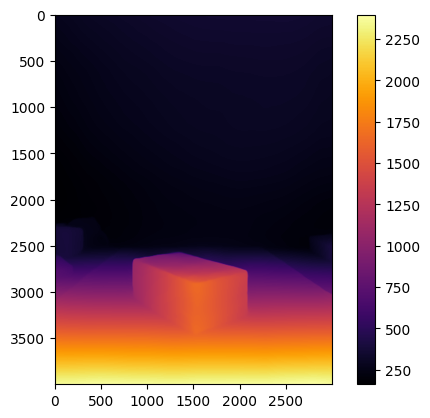

In [285]:

def improve_map(nnet_map, classical_map):
    mask = classical_map > 0
    coef = (( (classical_map) / (nnet_map) ) * mask).sum() / mask.sum()
    return nnet_map * coef

disp_improved = improve_map(disp_midas, filtered_disp_stereo)
print(disp_improved[:3])

# cv.drawContours(disp_improved, [corners], -1, (255,255,255), thickness=5)
plt.imshow(disp_improved, cmap = 'inferno')
plt.imsave("heatmap.jpg",disp_improved, cmap="inferno")
plt.colorbar()
plt.show()

coords_rw:
[[-0.3246397  -0.41929248  0.2071523 ]
 [-0.3247203  -0.3833839   0.20475729]
 [-0.3676742  -0.36567783  0.16828957]
 [-0.4207823  -0.39827687  0.2537193 ]
 [-0.4193317  -0.43071043  0.26418027]
 [-0.38040724 -0.43633667  0.35872453]]
distances:
[0.035988454, 0.059062995, 0.105742164, 0.034109715, 0.102398165]


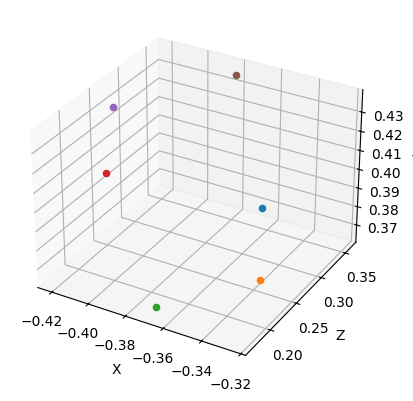

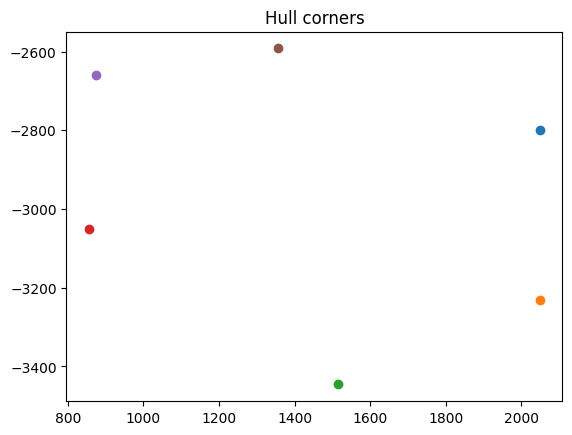

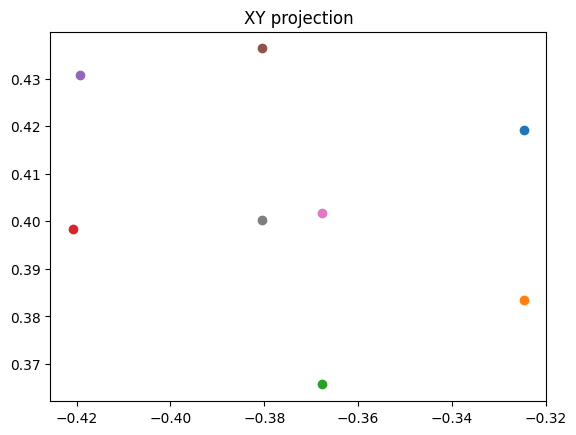

In [305]:
# print(f'Camera matrix:\n{intrinsics}')
coords_rw = find_rw(corners, disp_improved, intrinsics, b=0.016)
print(f'coords_rw:\n{coords_rw}')
distances = get_object_size(coords_rw)
print(f'distances:\n{distances}')
plot_points_3d(coords_rw)

for i in range(len(corners)):
    plt.scatter(corners[i,0], -corners[i,1])
plt.title("Hull corners")
plt.show()

# plot_hull(src, good_points, approx_ratio = 0.01)

for i in range(len(coords_rw)):
    plt.scatter(coords_rw[i,0], -coords_rw[i,1])
plt.title("XY projection")


height1 = np.linalg.norm(coords_rw[np.argsort(coords_rw[:,0])[-1]] - coords_rw[np.argsort(coords_rw[:,0])[-2]])
height2 = np.linalg.norm(coords_rw[np.argsort(coords_rw[:,0])[-1]] - coords_rw[np.argsort(coords_rw[:,0])[-2]])
height = (height1 + height2)/2

new_point = coords_rw[np.argsort(coords_rw[:,1])[-1]]
new_point[1] = new_point[1] - height
plt.scatter(new_point[0], -new_point[1])
coords_rw.tolist().append(new_point)

coords_rw = np.array(coords_rw)
new_point = coords_rw[np.argsort(coords_rw[:,1])[0]]
new_point[1] = new_point[1] + height
plt.scatter(new_point[0], -new_point[1])
plt.show()
coords_rw.tolist().append(new_point)
coords_rw = np.array(coords_rw)

In [ ]:


for i in range(100):
    